# **Laptop Price Prediction**

This is the final project for Machine Learning course at Shahid Beheshti University.

We collected data from Torob.ir using a web crawler tool called Selenium. Then we preprocessed the data using feature engineering techniques. In the following, you will see the description of each section.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#load dataset
df = pd.read_csv('drive/MyDrive/ML/data.csv', dtype=object)
fm = pd.read_csv('drive/MyDrive/ML/feature-mappings.csv' )
fm.drop(['not-null-count', 'example-1', 'example-2', 'example-3'], axis=1, inplace=True)
fm.loc[(fm['mapped-name'].isna() == False) & fm['mapped-name'].str.contains('usb'), 'how-to-extract-value'] = 'bool-number'

In [4]:
fm

,feature-name,mapped-name,how-to-extract-value
0,clean-graphic_ram,clean-gpu-memory-gb,number
1,clean-ram,clean-ram-gb,number
2,clean-cpu,clean-cpu-model,categorical
3,clean-hdd,clean-hdd-gb,unit-number
4,clean-screen_size,clean-display-size,number
...,...,...,...
1667,پردازنده مرکزی.تعداد هسته,cpu-cores,number
1668,باتری.ظرفیت,battery-wh,number
1669,صفحه نمایش. رزولوشن صفحه نمایش,display-res,max-number
1670,موارد کاربری,usage,categorical


In [5]:
# Create the first dictionary with unique 'feature-name' values for each 'mapped-name'
mapped_features = fm.groupby('mapped-name')['feature-name'].unique().apply(list).to_dict()

# Create the second dictionary with unique 'how-to-extract-value' values for each 'mapped-name'
mapped_methods = fm.groupby('mapped-name')['how-to-extract-value'].unique().apply(list).to_dict()

In [6]:
def transform_number(column_value, mode='first'):
    if pd.isna(column_value): return pd.NA

    # Replace Persian digit characters with their ASCII equivalent
    persian_digits = {'۰': '0', '۱': '1', '۲': '2', '۳': '3', '۴': '4',
                      '۵': '5', '۶': '6', '۷': '7', '۸': '8', '۹': '9'}

    for persian, ascii_digit in persian_digits.items():
        column_value = column_value.replace(persian, ascii_digit)

    # Remove any character that is not a digit, whitespace, or period
    cleaned_value = re.sub(r'[^\d\s.]', '', column_value)

    # Parse the remaining number tokens
    number_tokens = re.findall(r'\d+(?:\.\d+)?', cleaned_value)

    if len(number_tokens) > 0:
        # Convert number tokens to float
        numbers = [float(token) for token in number_tokens]

        if mode == 'min':
            return min(numbers)
        elif mode == 'max':
            return max(numbers)
        elif mode == 'first':
            return numbers[0]
        elif mode == 'int':
          for n in numbers:
            if n.is_integer():
              return n
            return numbers[0]
        else:
            raise ValueError("Invalid mode. Available modes are 'min', 'max', or 'first'.")
    else:
        return None

In [7]:
def transform_to_zero_one(value, zero_keywords=[]):
    zero_keywords += ['نه', 'خیر', 'ندارد', 'خير', '❌', 'no', 'نمی', 'نمي']

    if pd.isna(value):
      return pd.NA

    try:
        if float(value) == 0.0:
          return 0
    except ValueError:
      pass

    # Check if any zero keyword is present in the value
    if any(keyword in value for keyword in zero_keywords):
        return 0
    else:
        return 1

In [8]:
def transform_unit(value, coeff=1e0):
  if pd.isna(value): return pd.NA

  giga = ['gb', 'گیگا', 'گيگا']
  mega = ['mb', 'مگا']
  tera = ['tb', 'ترا']

  n = transform_number(value)
  if n is None:
    return None

  if any(part in value for part in giga):
    coeff = 1e9 / coeff
  elif any(part in value for part in mega):
    coeff = 1e6 / coeff
  elif any(part in value for part in tera):
    coeff = 1e12 / coeff

  return n * coeff

In [9]:
def transform_categorical(value, categories):
  if pd.isna(value): return pd.NA

  for category in categories:
    if any(c in value.strip().lower() for c in category):
      return category[0]
  return pd.NA

In [10]:
def transform_weight(value):
  if pd.isna(value): return pd.NA

  kilo = ['kg', 'کیلو', 'کيلو']
  geram = ['گرم']

  n = transform_number(value)

  if any(part in value for part in geram) and not any(part in value for part in kilo):
    return n / 1000
  return n

In [11]:
def transform_bool_number(value):
  n = transform_number(value, mode='int')
  if pd.isna(n) or not bool(n):
    n = transform_to_zero_one(value)
  return n

In [12]:
fm['how-to-extract-value'].dropna().unique()

array(['number', 'categorical', 'unit-number', 'max-number', 'boolean',
       'manual', 'min-number', 'bool-number', 'weight-number'],
      dtype=object)

In [13]:
# transform columns
index = 0
for c in df.columns:
  index += 1
  original_c = c
  if len(fm[fm['feature-name'] == c]['how-to-extract-value']) == 0:
    c = c.strip()
    if len(fm[fm['feature-name'] == c]['how-to-extract-value']) == 0:
      print(f'fatal: unknown feature {c}')

  method = fm[fm['feature-name'] == c]['how-to-extract-value'].iloc[0]
  m_name = fm[fm['feature-name'] == c]['mapped-name'].iloc[0]

  c = original_c
  if index % 25 == 0:
    print(str(index).rjust(4, '0'), '----- processing: ', c, method, m_name)
  if method == 'number':
    df[c] = df[c].apply(transform_number)
  elif method == 'min-number':
    df[c] = df[c].apply(transform_number, args=('min',))
  elif method == 'max-number':
    df[c] = df[c].apply(transform_number, args=('max',))
  elif method == 'unit-number':
    if m_name.endswith('-gb'):
      df[c] = df[c].apply(transform_unit, args=(1e9,))
    elif m_name.endswith('-mb') or m_name.endswith('-mhz'):
      df[c] = df[c].apply(transform_unit, args=(1e6,))
    elif m_name.endswith('-tb'):
      df[c] = df[c].apply(transform_unit, args=(1e12,))
    else:
      raise ValueError(f'unknown mapped_name {m_name} uses unit-number')
  elif method == 'weight-number':
      df[c] = df[c].apply(transform_weight)
  elif method == 'bool-number':
      df[c] = df[c].apply(transform_bool_number)
  elif method == 'boolean':
      df[c] = df[c].apply(transform_to_zero_one)
  elif method == 'categorical':
    pass
  else:
    df.drop([c], axis=1, inplace=True)

df

0025 ----- processing:  مشخصات ویژه برای اتصالات nan nan
0050 ----- processing:  هسته پردازشی min-number cpu-cores
0075 ----- processing:  Mini HDMI boolean hdmi-has
0100 ----- processing:  تعداد درگاه USB 2.0 Type A bool-number usb2
0125 ----- processing:  نوع باتري nan nan
0150 ----- processing:  کشور سازنده categorical country
0175 ----- processing:  سایر نرم افزارها nan nan
0200 ----- processing:  جک میکروفون boolean jack-has
0225 ----- processing:  امکانات.حسگر اثر انگشت boolean has-security-id
0250 ----- processing:  ظرفیت-هارد unit-number storage-hdd-gb
0275 ----- processing:  مقدار حافظه گرافیکی number gpu-memory-gb
0300 ----- processing:  پشتیبانی از سیم‌کارت nan nan
0325 ----- processing:  امکانات.بلوتوث boolean bluetooth
0350 ----- processing:  Processor Type categorical cpu-model
0375 ----- processing:  پردازنده مرکزی.فرکانس پردازنده nan nan
0400 ----- processing:  فرکانس پردازنده گرافیکی number gpu-freq-mhz
0425 ----- processing:  RAM Reader boolean sd-card-has-port
0450 -

,تعداد رشته (Thread),سایز,برند\t\t\t\t\n\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\tریزر بلید Razer Blade,برند و سری,پورت Mini HDMI,KEYBOARD BACKLIGHT,بلوتوث داخلی,نوع کاربری لپتاپ,نوع حافظه گرافیک,کاربردهای خاص برای محصول چند رسانه ای,...,درگاه کارت حافظه,تعداد پورت USB 4.0,قابلیت ارتقاء حافظه (هارد),DP/Type C,نور پس زمینه کیبرد,ویژگی های خاص,پردازنده مرکزي.حافظه Cache,نوع اتصال,درگاه حافظه,Touch ID
0,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GDDR6,NaN,...,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN
1,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN
2,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN
3,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN
4,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1167,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1168,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1169,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1170,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
df.to_csv('drive/MyDrive/ML/transformed.csv')

In [15]:
def join_cols(row):
  r = row.dropna()
  if len(r) == 0:
    return np.nan
  if len(r) != 1:
    if type(r.iloc[0]) == float or type(r.iloc[0]) == int:
      return np.mean(r)
    return ' '.join(r.astype(str))
  return r.iloc[0]

df = df.rename(columns=str.strip)
mapped_df = pd.DataFrame()
# Iterate through each column group
for new_column, old_columns in mapped_features.items():
    # Create a new column by joining the values from old columns
    old_columns = set(old_columns).intersection(set(df.columns))
    mapped_df[new_column] = df[old_columns].apply(join_cols, axis=1)

mapped_df

,aspect-ratio,battery-life,battery-wh,bluetooth,brand,cam-resolution,clean-cpu-model,clean-display-size,clean-gpu-memory-gb,clean-hdd-gb,...,thunderbolt-has,title,touch-screen-has,usage,usb2,usb3,usb4,usbc,weight,weight-pound
0,NaN,NaN,45.0,1.0,Lenovo | لنوو,NaN,NaN,NaN,NaN,NaN,...,NaN,لپ تاپ لنوو IdeaPad Gaming 3 | 16GB RAM | 512G...,0.0,NaN,0.0,0.666667,NaN,1.0,2.31,NaN
1,NaN,15.0,49.9,1.0,Apple,NaN,NaN,NaN,NaN,NaN,...,1.0,مک بوک ایر 8GB RAM | 256GB SSD | M1 | MGN63 ا ...,0.0,"کاربری عمومی , باریک و سبک",NaN,NaN,1.5,1.0,1.29,NaN
2,NaN,2.0,35.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,لپ تاپ لنوو Ideapad 3 | 12GB RAM | 256GB SSD |...,0.0,NaN,1.0,2.000000,NaN,0.0,1.70,NaN
3,NaN,3.0,76.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,لپ تاپ ایسوس FX517ZR | 16GB RAM | 512GB SSD | ...,NaN,"برنامه نویسی, تدوین, طراحی, گیمینگ",NaN,2.000000,NaN,4.0,2.00,NaN
4,NaN,4.0,35.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,لپ تاپ لنوو Ideapad 3 | 4GB RAM | 1TB HDD | ...,0.0,NaN,1.0,2.000000,NaN,0.0,0.85,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1167,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,لپ تاپ لنوو Lenovo Thinkpad T480 ا lenovo thin...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1168,NaN,500.0,33.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,لپ تاپ ایسوس 15.6 اینچی مدل VivoBook X540YA پر...,0.0,کاربری عمومی,NaN,NaN,NaN,1.0,2.00,NaN
1169,NaN,NaN,35.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,لپ تاپ لنوو V15 | 12GB RAM | 1TB HDD | 128GB ...,0.0,NaN,1.0,0.666667,NaN,0.0,1.85,NaN
1170,NaN,NaN,48.0,1.0,ASUS,NaN,NaN,NaN,NaN,NaN,...,NaN,لپ تاپ ایسوس 17 اینچی مدل FX706HC پردازنده Cor...,0.0,NaN,0.0,3.000000,NaN,NaN,2.60,NaN


In [77]:
mapped_df.to_csv('drive/MyDrive/ML/mapped.csv')

In [78]:
fm[fm['how-to-extract-value'] == 'categorical']['mapped-name'].value_counts()

usage              31
gpu-model          28
cpu-model          27
gpu-brand          21
storage-type       21
os                 18
display-type       17
cpu-brand          17
brand              15
ram-type           14
gpu-memory-type     8
country             4
storage-port        3
aspect-ratio        2
ram-interface       1
title               1
ssd-port            1
clean-cpu-model     1
Name: mapped-name, dtype: int64

In [79]:
mapped_df['storage-connection-pcie'].unique()

array([      nan, 4.000e+00, 3.000e+00, 4.016e+00, 4.168e+03])

In [80]:
categories = {
  'usage': [['game', 'گیم', 'گيم', 'حرفه'], ['media', 'مدیا', 'مالتی', 'مديا']],
  'gpu-model': [['rtx'], ['gtx', 'geforce', 'nvidia'], ['intel', 'iris'], ['amd', 'radeon'], ['apple']],
  'cpu-model': [['i3'], ['i5'], ['i7'], ['i9'], ['ryzen-high', 'ryzen 9', 'ryzen 8', 'ryzen 7'], ['ryzen-low', 'ryzen'], ['m1'], ['m2'], ['carrizo'], ['celeron']],
  'storage-type': [['nvme'], ['pcie'], ['m2', 'm.2'], ['hybrid', 'هیبرید'], ['emmc']],
  'gpu-brand': [['nvidia', 'gtx', 'geforce'], ['apple'], ['intel'], ['amd', 'radeon']],
  'os': [['dos'], ['mac'], ['windows', 'ویندوز', 'ويندوز']],
  'cpu-brand': [['intel'], ['amd']],
  'display-type': [['oled'], ['ips'], ['led'], ['tft'], ['tn']],
  'title': [['lenovo', 'لنوو', 'legion'], ['asus', 'ایسوس', 'rog', 'tuf'], ['hp', 'اچ‌پی'], ['dell', 'دل'], ['acer', 'ایسر'], ['apple', 'اپل', 'mac'], ['msi'], ['microsoft', 'surface', 'سرفیس'], ['toshiba', 'توشیبا'], ['huawei', 'huawei'], ['xiaomi', 'شیائومی'], ['razer', 'ریزر'], ['vaio'], ['sony', 'سونی'], ['samsung', 'سامسونگ']],
  'ram-type': [['ddr4'], ['ddr5'], ['ddr3']],
  'gpu-memory-type': [['ddr4'], ['ddr5'], ['ddr3']],
  'country': [['america', 'آمریکا'], ['taiwan', 'تایوان'], ['china', 'چین']],
  'aspect-ratio': [['16:9'], ['3:2'], ['16:10']],
  'clean-cpu-model': 'same',
  'ram-interface': [['128'], ['256']],
  'ssd-port': [['1', '']],
}

mapped_df_cat = mapped_df
def transform_category(value, groups):
  if pd.isna(value):
    return np.nan
  for g in groups:
    if any(key in value.lower() for key in g):
      return g[0]
  return np.nan

for col in fm[fm['how-to-extract-value'] == 'categorical']['mapped-name'].dropna().unique():
  if col not in categories:
    if col in mapped_df_cat.columns:
      mapped_df_cat.drop([col], axis=1, inplace=True)
    continue
  mapped_df_cat[col] = mapped_df_cat[col].apply(transform_category, args=(categories[col],))

In [81]:
mapped_df_cat.to_csv('drive/MyDrive/ML/mapped_with_categorical.csv')

In [82]:
new_df = pd.read_csv('drive/MyDrive/ML/mapped_with_categorical.csv')

We had a small problem here finding null values of some specific columns in our csv file. We had to get a duplicate of it (*clean_df*) and then split our wanted columns. Next we merged the correspandent columns.

In [83]:
clean_df = pd.read_csv('drive/MyDrive/ML/mapped_with_categorical.csv',na_values="NaN")
clean_df = clean_df[['clean-cpu-model','clean-display-size','clean-gpu-memory-gb','clean-hdd-gb','clean-ram-gb','clean-ssd-gb']]
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1172 entries, 0 to 1171
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   clean-cpu-model      0 non-null      float64
 1   clean-display-size   0 non-null      float64
 2   clean-gpu-memory-gb  0 non-null      float64
 3   clean-hdd-gb         0 non-null      float64
 4   clean-ram-gb         0 non-null      float64
 5   clean-ssd-gb         0 non-null      float64
dtypes: float64(6)
memory usage: 55.1 KB


In [84]:
new_df.shape

(1172, 80)

## Explore and understand the features

In [85]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1172 entries, 0 to 1171
Data columns (total 80 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unnamed: 0               1172 non-null   int64  
 1   aspect-ratio             9 non-null      object 
 2   battery-life             629 non-null    float64
 3   battery-wh               824 non-null    float64
 4   bluetooth                746 non-null    float64
 5   cam-resolution           3 non-null      float64
 6   clean-cpu-model          0 non-null      float64
 7   clean-display-size       0 non-null      float64
 8   clean-gpu-memory-gb      0 non-null      float64
 9   clean-hdd-gb             0 non-null      float64
 10  clean-ram-gb             0 non-null      float64
 11  clean-ssd-gb             0 non-null      float64
 12  country                  303 non-null    object 
 13  cpu-brand                846 non-null    object 
 14  cpu-cache-mb            

As we can see, we have some features with very few values and lots of missing values. We tried imputing the missing values by most-frequent strategy or mean-encoding but we got unbalanced data and our model wasn't working perfectly. So we dropped them:

In [86]:
Nan_list = [0,1,2,3,5,12,15,16,17,18,19,20,21,23,24,26,27,28,30,32,33,34,37,38,39,40,41,42,43,44,45,46,47,48,50,52,54,55,56,57,58,62,63,64,67,69,70]
new_df.drop(new_df.columns[Nan_list], axis=1, inplace=True)

In [87]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1172 entries, 0 to 1171
Data columns (total 33 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   bluetooth            746 non-null    float64
 1   clean-cpu-model      0 non-null      float64
 2   clean-display-size   0 non-null      float64
 3   clean-gpu-memory-gb  0 non-null      float64
 4   clean-hdd-gb         0 non-null      float64
 5   clean-ram-gb         0 non-null      float64
 6   clean-ssd-gb         0 non-null      float64
 7   cpu-brand            846 non-null    object 
 8   cpu-cache-mb         964 non-null    float64
 9   display-size         1023 non-null   float64
 10  gpu-brand            699 non-null    object 
 11  gpu-memory-gb        769 non-null    float64
 12  gpu-model            896 non-null    object 
 13  has-multi-touch      436 non-null    float64
 14  has-security-id      661 non-null    float64
 15  os                   458 non-null    o

We didn't use pd.concat to merge the column of clean_df and new_df. Instead, we used combine_first which iterates thorough column and fill each missing value in first column with its correspanding value in second column if it's not null.

In [88]:
new_df['gpu-memory-gb'] = new_df['gpu-memory-gb'].combine_first(clean_df['clean-gpu-memory-gb'])
new_df.drop(columns=['clean-gpu-memory-gb'], inplace=True)

new_df['storage-hdd-gb'] = new_df['storage-hdd-gb'].combine_first(clean_df['clean-hdd-gb'])
new_df.drop(columns=['clean-hdd-gb'], inplace=True)

new_df['ram-gb'] = new_df['ram-gb'].combine_first(clean_df['clean-ram-gb'])
new_df.drop(columns=['clean-ram-gb'], inplace=True)

new_df['storage-ssd-gb'] = new_df['storage-ssd-gb'].combine_first(clean_df['clean-ssd-gb'])
new_df.drop(columns=['clean-ssd-gb'], inplace=True)

new_df['display-size'] = new_df['display-size'].combine_first(clean_df['clean-display-size'])
new_df.drop(columns=['clean-display-size'], inplace=True)

In [89]:
new_df.drop(columns=['clean-cpu-model'], inplace=True)

In [90]:
new_df['ram-gb'].fillna(new_df['ram-gb'].mode()[0], inplace=True)
new_df['ram-gb'] = new_df['ram-gb'].astype(int)

new_df['gpu-memory-gb'].fillna(new_df['gpu-memory-gb'].mode()[0], inplace=True)
new_df['gpu-memory-gb'] = new_df['gpu-memory-gb'].astype(int)

new_df['cpu-cache-mb'].fillna(new_df['cpu-cache-mb'].mode()[0], inplace=True)
new_df['cpu-cache-mb'] = new_df['cpu-cache-mb'].astype(int)

By observing the dataset we can understand that we can replace rtx and gtx type with nvidia type. Also we realize that columns 'gpu-brand' and 'gpu-model' can be merged together. By doing this, we have helped to balance the data in this column.



In [91]:
new_df['gpu-model'].value_counts()

rtx      444
gtx      213
intel    163
amd       58
apple     18
Name: gpu-model, dtype: int64

In [92]:
new_df['gpu-model'] = new_df['gpu-model'].replace({'rtx': 'nvidia', 'gtx':'nvidia'})

new_df['gpu-brand'] = new_df['gpu-brand'].combine_first(new_df['gpu-model'])
new_df.drop(columns=['gpu-model'], inplace=True)

We split the numerical and categorical features so we can impute missing values in categorical coolumns with most frequent values or 'Unknown' label.

In [93]:
numerical_features = new_df.select_dtypes(include='int64').columns
numerical_features = new_df.select_dtypes(include='float64').columns
categorical_features = new_df.select_dtypes(include='object').columns.tolist()

In [94]:
new_df['cpu-brand'] = new_df['cpu-brand'].fillna('intel')
new_df['os'] = new_df['os'].fillna('No OS')
new_df['usage'] = new_df['usage'].fillna('Unknown')
new_df['gpu-brand'] = new_df['gpu-brand'].fillna('Unknown')
new_df['title'] = new_df['title'].fillna('Unknown')

In [95]:
for column in categorical_features:
    unique_values = new_df[column].unique()
    print(f"Unique values in column '{column}': {unique_values}")
    print()

Unique values in column 'cpu-brand': ['intel' 'amd']

Unique values in column 'gpu-brand': ['nvidia' 'apple' 'intel' 'Unknown' 'amd']

Unique values in column 'os': ['No OS' 'mac' 'dos' 'windows']

Unique values in column 'title': ['lenovo' 'apple' 'asus' 'hp' 'microsoft' 'dell' 'huawei' 'acer' 'msi'
 'samsung' 'Unknown' 'toshiba' 'xiaomi' 'razer' 'sony']

Unique values in column 'usage': ['Unknown' 'game' 'media']



In [96]:
from sklearn.manifold import TSNE

selected_features = pd.get_dummies(new_df[categorical_features])

tsne = TSNE(
    n_components=2,
    n_iter=500,
    n_iter_without_progress=150,
    n_jobs=2,
    random_state=0,
)
tsne_result = tsne.fit_transform(selected_features)

tsne_df = pd.DataFrame(
    np.c_[tsne_result, new_df['price']],
    columns=['x', 'y', 'price']
)

plt.figure(figsize=(8, 5))
sns.scatterplot(tsne_df, x="x", y="y", hue="price", s=50, alpha=.8)
plt.title('t-SNE Visualization of Categorical Features')
plt.show()

KeyboardInterrupt: ignored

<Axes: >

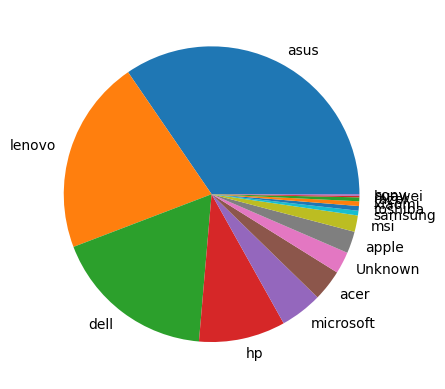

In [ ]:
new_df.value_counts('title').plot(kind='pie')

<Axes: >

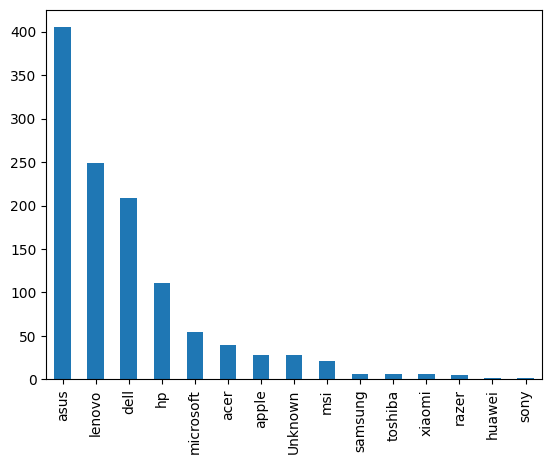

In [ ]:
new_df["title"].value_counts().plot(kind="bar")

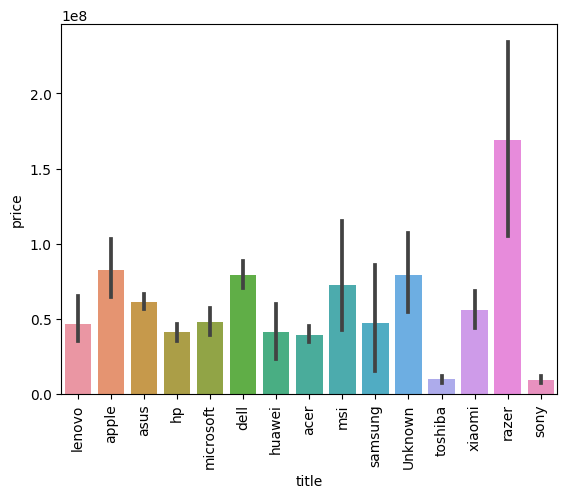

In [ ]:
sns.barplot(x=new_df["title"],y=new_df["price"])
plt.xticks(rotation="vertical")
plt.show()

<Axes: >

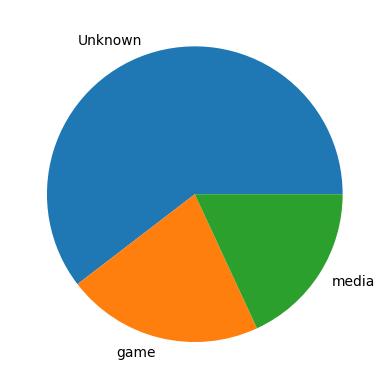

In [ ]:
new_df.value_counts('usage').plot(kind='pie')

<Axes: >

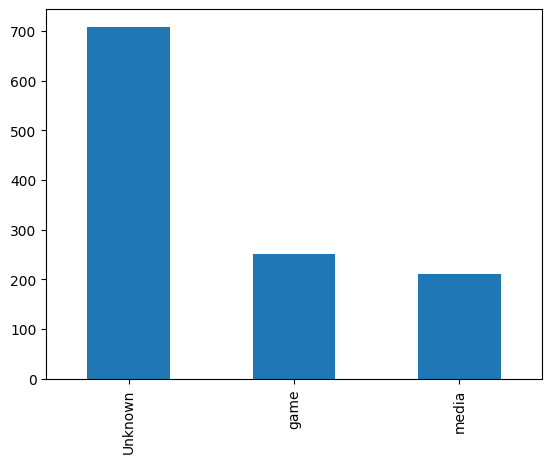

In [ ]:
new_df["usage"].value_counts().plot(kind="bar")

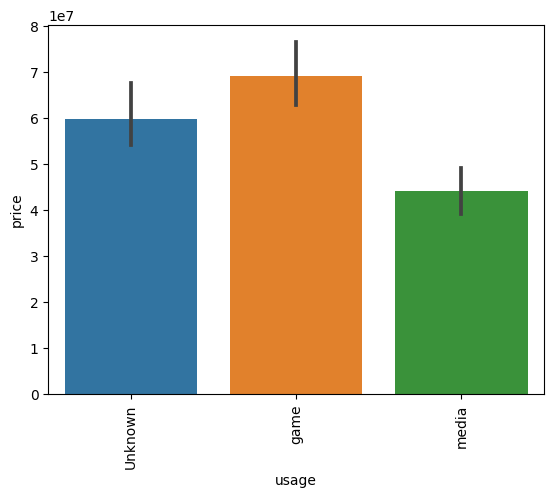

In [97]:
sns.barplot(x=new_df["usage"],y=new_df["price"])
plt.xticks(rotation="vertical")
plt.show()

In column 'storage-hdd-tb' we only have one value. we convert it to gb, merge it with 'storage-hdd-gb' and drop this column.

In [98]:
new_df['storage-hdd-tb'] = new_df['storage-hdd-tb'] * 1000
new_df['storage-hdd-gb'] = new_df['storage-hdd-gb'].combine_first(new_df['storage-hdd-tb'])
new_df.drop(columns=['storage-hdd-tb'], inplace=True)

In [99]:
new_df['storage-hdd-gb'] = new_df['storage-hdd-gb'].fillna(0)
new_df['storage-ssd-gb'] = new_df['storage-ssd-gb'].fillna(0)

<Axes: xlabel='cpu-cache-mb', ylabel='price'>

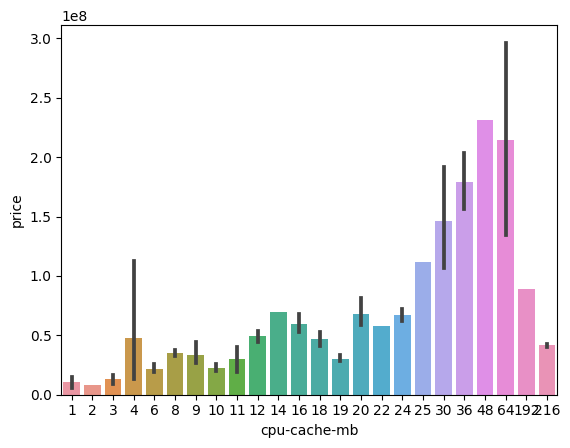

In [ ]:
sns.barplot(x=new_df["cpu-cache-mb"],y=new_df["price"])

<Axes: xlabel='gpu-memory-gb', ylabel='price'>

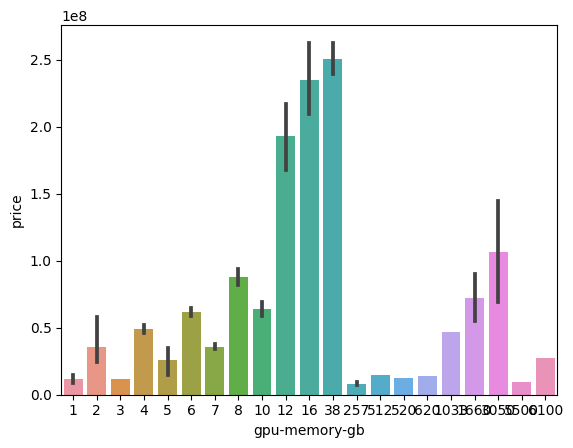

In [ ]:
sns.barplot(x=new_df["gpu-memory-gb"],y=new_df["price"])

We delete records that have missing value in price column.

In [100]:
new_df = new_df.dropna(subset=['price'])
new_df['price'] = new_df['price'] / 10e6

<Axes: xlabel='price', ylabel='Count'>

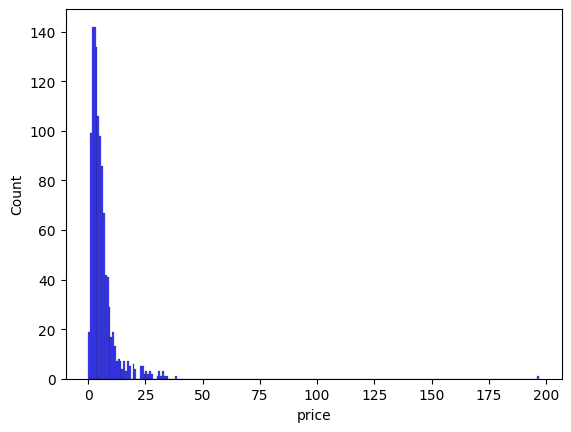

In [101]:
sns.histplot(new_df['price'],color='blue')

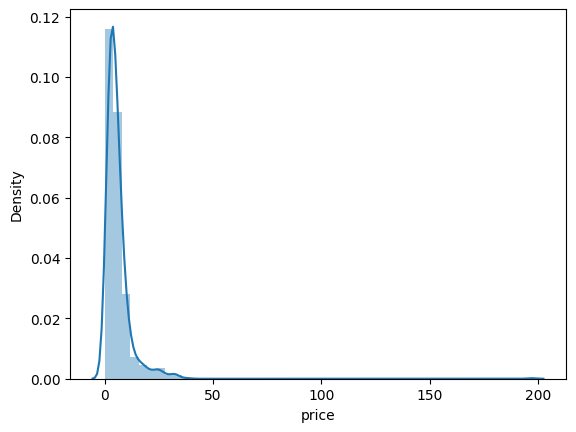

In [102]:
sns.distplot(new_df['price'])
plt.show()

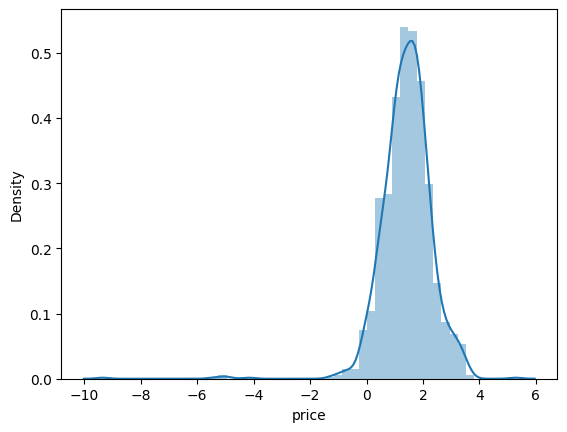

In [40]:
sns.distplot(np.log(new_df['price']))
plt.show()

These columns show number of each kind of ports. We fill the missing values with 0. collect them all and put sum of them in a a new column called 'usb-ports' which shows number of all usb ports a laptop has.

In [103]:
Nan_list = ['usb2', 'usb3', 'usb4', 'usbc']
for Columns in Nan_list:
  new_df[Columns] = new_df[Columns].fillna(0)

new_df[['usb2', 'usb3', 'usb4', 'usbc']] = new_df[['usb2', 'usb3', 'usb4', 'usbc']].astype(int)
new_df['usb-ports'] = new_df['usb2'] + new_df['usb3'] + new_df['usb4'] + new_df['usbc']
new_df['usb-ports'] = new_df['usb-ports'].fillna(0)
new_df.drop(columns=['usb2', 'usb3','usb4', 'usbc'], inplace=True)

We have a column called 'weight-pound' but it has lots of missing values. we do the same thing about this one as we did before for 'storage-hdd-tb'.

In [104]:
conversion_factor = 0.45
new_df['weight-pound'] = new_df['weight-pound'] * 0.45

new_df['weight-kg'] = new_df['weight'].combine_first(new_df['weight-pound'])
new_df.drop(columns=['weight-pound'], inplace=True)

In [105]:
new_df.drop(columns=['weight'], inplace=True)

In [106]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1146 entries, 0 to 1171
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   bluetooth         738 non-null    float64
 1   cpu-brand         1146 non-null   object 
 2   cpu-cache-mb      1146 non-null   int64  
 3   display-size      1012 non-null   float64
 4   gpu-brand         1146 non-null   object 
 5   gpu-memory-gb     1146 non-null   int64  
 6   has-multi-touch   430 non-null    float64
 7   has-security-id   651 non-null    float64
 8   os                1146 non-null   object 
 9   price             1146 non-null   float64
 10  ram-gb            1146 non-null   int64  
 11  size              38 non-null     float64
 12  size-inch         11 non-null     float64
 13  size-mm           948 non-null    float64
 14  storage-hdd-gb    1146 non-null   float64
 15  storage-ssd-gb    1146 non-null   float64
 16  title             1146 non-null   object 


The laptops with weight above 5kg, have a wrong unit of gram. We convert the unit here.

In [107]:
new_df.loc[new_df['weight-kg'] > 5, 'weight-kg'] = new_df['weight-kg'] / 1000

<Axes: ylabel='Density'>

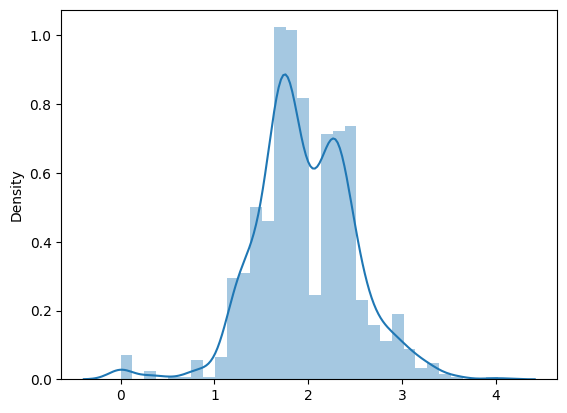

In [108]:
sns.distplot(x=new_df["weight-kg"])

<Axes: xlabel='weight-kg', ylabel='price'>

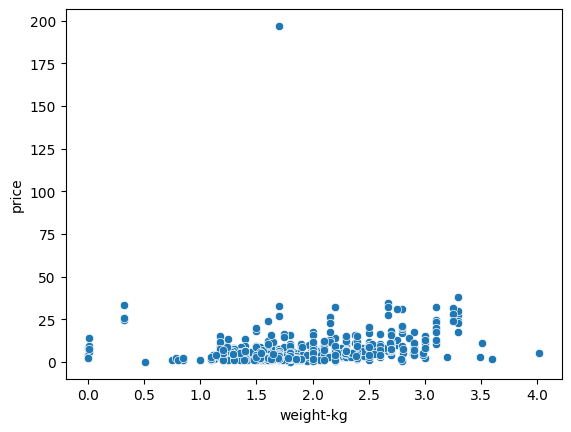

In [109]:
sns.scatterplot(x="weight-kg",y="price",data=new_df)

We have a column called 'size-mm' but it has lots of missing values. we do the same thing about this one as we did before for 'storage-hdd-tb' and 'weight-pound'. Convert mm to inches and merge columns.

In [110]:
new_df['size'] = new_df['size'].combine_first(new_df['size-inch'])
new_df.drop(columns=['size-inch'], inplace=True)

In [111]:
new_df['size-mm'] = new_df['size-mm'] / 25.4
new_df['size-mm'] = new_df['size-mm'].round(2)

new_df['size'] = new_df['size'].combine_first(new_df['size-mm'])
new_df.drop(columns=['size-mm'], inplace=True)

In [112]:
new_df['size'] = new_df['size'].combine_first(new_df['display-size'])
new_df.drop(columns=['display-size'], inplace=True)

<Axes: xlabel='size', ylabel='price'>

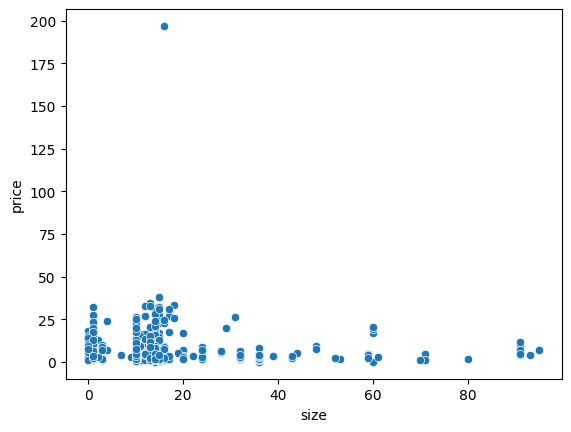

In [125]:
sns.scatterplot(x="size",y="price",data=new_df)

All the columns that have 'has' in their name is boolean. We consider these columns with 0 as false and  as true.

In [114]:
new_df['bluetooth'] = new_df['bluetooth'].fillna(0)

has_columns = [col for col in new_df.columns if 'has' in col]
new_df[has_columns] = new_df[has_columns].fillna(0)

In [115]:
new_df['bluetooth'] = new_df['bluetooth'].astype(int)
for column in has_columns:
        new_df[column] = new_df[column].astype(int)

<Axes: >

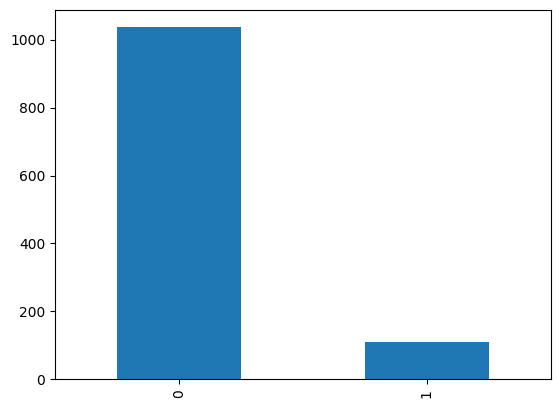

In [54]:
new_df["touch-screen-has"].value_counts().plot(kind="bar")

<Axes: xlabel='touch-screen-has', ylabel='price'>

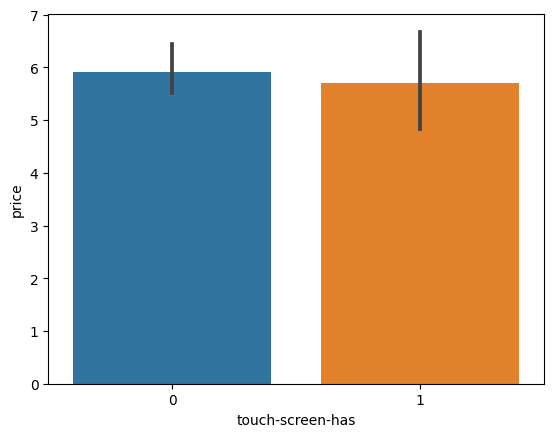

In [ ]:
sns.barplot(x=new_df["touch-screen-has"],y=new_df["price"])

We fill missing values in 'size' and 'weight-kg' columns using mean-enconding.

In [116]:
num_mean = ['size', 'weight-kg']
for column in num_mean:
    mean_value = new_df[column].mean()
    new_df[column].fillna(mean_value, inplace=True)

Then by using value_counts() we realize that we have some unbalanced values within our data. The divide_values method is for this matter.

In [124]:
new_df['size'].value_counts()

14    334
13    128
15    124
10     88
1      82
12     79
16     48
0      45
36     39
20     31
11     28
24     26
32     15
2      13
3      13
17      7
91      7
28      5
60      4
59      3
71      2
4       2
9       2
43      2
48      2
95      2
18      2
19      1
93      1
52      1
22      1
61      1
39      1
80      1
53      1
70      1
44      1
7       1
31      1
29      1
Name: size, dtype: int64

In [123]:
def divide_values(value):
    if value > 100:
        return int(value / 100)
    else:
        return int(value)

new_df['size'] = new_df['size'].apply(divide_values)

In [126]:
new_df['weight-kg'] = new_df['weight-kg'].round(2)
new_df['weight-kg'] = new_df['weight-kg'].replace({0:4})
new_df["weight-kg"].value_counts()

1.96    142
1.80     98
1.70     82
2.30     81
2.00     66
       ... 
3.51      1
0.51      1
1.87      1
1.99      1
2.21      1
Name: weight-kg, Length: 122, dtype: int64

In [ ]:
new_df['weight-kg'] = new_df['weight-kg'].apply(divide_values)

By using correlation we can find out which columns have the least impact on our target so we can remove them.

In [130]:
new_df.corr()['price']

bluetooth          0.040247
cpu-cache-mb       0.225870
has-multi-touch   -0.091269
has-security-id    0.017470
price              1.000000
ram-gb             0.379062
size              -0.035705
usb-ports          0.052904
weight-kg          0.196571
Name: price, dtype: float64

In [128]:
new_df.drop(columns=['gpu-memory-gb','storage-hdd-gb','storage-ssd-gb','touch-screen-has',],inplace=True)

<Axes: >

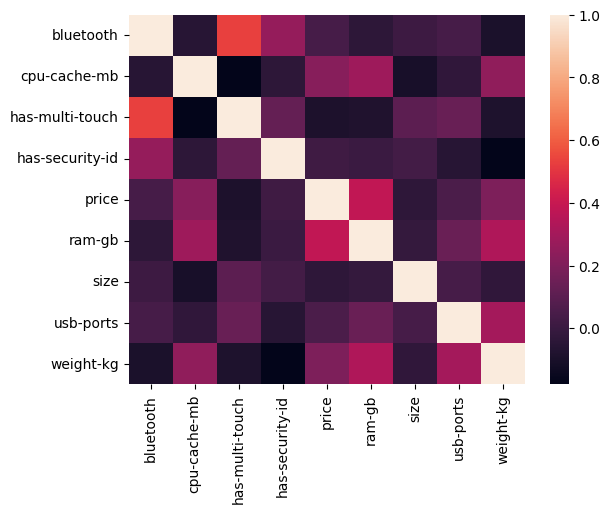

In [129]:
sns.heatmap(new_df.corr())

# **Building the model**

In [131]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, make_scorer
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.svm import SVR

In [133]:
y = np.log(new_df['price'])
X = new_df.drop('price', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape)

(916, 13) (230, 13)


We create a sklearn pipeline to one-hot encoding for categoricals and to build and train our model.

In [136]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 916 entries, 730 to 1151
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   bluetooth        916 non-null    int64  
 1   cpu-brand        916 non-null    object 
 2   cpu-cache-mb     916 non-null    int64  
 3   gpu-brand        916 non-null    object 
 4   has-multi-touch  916 non-null    int64  
 5   has-security-id  916 non-null    int64  
 6   os               916 non-null    object 
 7   ram-gb           916 non-null    int64  
 8   size             916 non-null    int64  
 9   title            916 non-null    object 
 10  usage            916 non-null    object 
 11  usb-ports        916 non-null    int64  
 12  weight-kg        916 non-null    float64
dtypes: float64(1), int64(7), object(5)
memory usage: 100.2+ KB


##LinearRegression (Lasso)

In [137]:
ohe = ColumnTransformer(transformers=[
    ('col_tnf',OneHotEncoder(sparse=False,drop='first'),[1,3,6,10,9])
],remainder='passthrough')

model = Lasso(alpha=0.001)

pipe = Pipeline([
    ('step1',ohe),
    ('step2',model)
])

pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)

print('R2 score',r2_score(y_test, y_pred))
print('MAE',mean_absolute_error(y_test, y_pred))

R2 score 0.44278968119922746
MAE 0.39844336832842486


In [138]:
errors = abs(y_pred - y_test)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

mape = 100 * (errors / y_test)
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Mean Absolute Error: 0.4 degrees.
Accuracy: 78.9 %.


## KNeighborsRegressor

In [139]:
ohe = ColumnTransformer(transformers=[
    ('col_tnf',OneHotEncoder(sparse=False,drop='first'),[1,3,6,10,9])
],remainder='passthrough')

model = KNeighborsRegressor(n_neighbors=3)

pipe = Pipeline([
    ('step1',ohe),
    ('step2',model)
])

pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)

print('R2 score',r2_score(y_test, y_pred))
print('MAE',mean_absolute_error(y_test, y_pred))

R2 score 0.45795976506205316
MAE 0.34700755495787816


In [140]:
errors = abs(y_pred - y_test)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

mape = 100 * (errors / y_test)
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Mean Absolute Error: 0.35 degrees.
Accuracy: 77.86 %.


## SVR

In [141]:
ohe = ColumnTransformer(transformers=[
    ('col_tnf',OneHotEncoder(sparse=False,drop='first'),[1,3,6,10,9])
],remainder='passthrough')

model = SVR(kernel='rbf',C=10000,epsilon=0.1)

pipe = Pipeline([
    ('step1',ohe),
    ('step2',model)
])

pipe.fit(X_train,y_train)

y_pred = pipe.predict(X_test)

print('R2 score',r2_score(y_test, y_pred))
print('MAE',mean_absolute_error(y_test, y_pred))

R2 score 0.029215258482119588
MAE 0.408847848118204


In [142]:
errors = abs(y_pred - y_test)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

mape = 100 * (errors / y_test)
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Mean Absolute Error: 0.41 degrees.
Accuracy: 61.85 %.


## Decision Tree Regressor

In [143]:
ohe = ColumnTransformer(transformers=[
    ('col_tnf',OneHotEncoder(sparse=False,drop='first'),[1,3,6,10,9])
],remainder='passthrough')


model = DecisionTreeRegressor(
    min_samples_split=10,
    max_features="auto",
    random_state=2,
    max_depth=9
)


pipe = Pipeline([
    ('step1',ohe),
    ('step2',model)
])

pipe.fit(X_train,y_train)

y_pred = pipe.predict(X_test)

print('R2 score',r2_score(y_test, y_pred))
print('MAE',mean_absolute_error(y_test, y_pred))

R2 score 0.36930537518457984
MAE 0.374403321346989


In [144]:
margin_error = pd.DataFrame({'Actual Price': y_test, 'Predicted value': y_pred, 'Margin of error': y_test-y_pred})
margin_error[0:20]

,Actual Price,Predicted value,Margin of error
218,0.145830,0.205433,-0.059603
820,2.170196,1.854825,0.315371
505,0.916291,0.950256,-0.033966
656,2.208274,1.528397,0.679878
324,0.593272,0.725838,-0.132566
510,0.117783,0.122949,-0.005166
1024,1.128171,0.480997,0.647174
107,1.098612,1.529331,-0.430718
739,1.007593,0.942552,0.065040
170,1.257949,1.529331,-0.271381


In [145]:
errors = abs(y_pred - y_test)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

mape = 100 * (errors / y_test)
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Mean Absolute Error: 0.37 degrees.
Accuracy: 81.33 %.


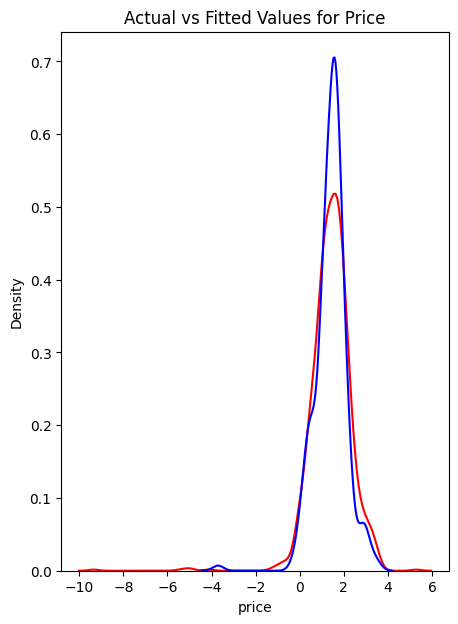

In [146]:
plt.figure(figsize=(5, 7))

ax = sns.distplot(y, hist=False, color="r", label="Actual Value")
sns.distplot(y_pred, hist=False, color="b", label="Fitted Values" , ax=ax)

plt.title('Actual vs Fitted Values for Price')
plt.show()
plt.close()

## XGBoost Regressor

In [147]:
ohe = ColumnTransformer(transformers=[
    ('col_tnf',OneHotEncoder(sparse=False,drop='first'),[1,3,6,10,9])
],remainder='passthrough')


model = xgb.XGBRegressor(objective='reg:squarederror')

pipe = Pipeline([
    ('step1',ohe),
    ('step2',model)
])

pipe.fit(X_train,y_train)

y_pred = pipe.predict(X_test)

print('R2 score',r2_score(y_test,y_pred))
print('MAE',mean_absolute_error(y_test,y_pred))

R2 score 0.37180893713869756
MAE 0.3247269179451763


In [148]:
# Evaluate the margin of error.
df_py = pd.DataFrame({'Actual Price': y_test, 'Predicted value': y_pred, 'Margin of error': y_test-y_pred})
df_py[0:20]

,Actual Price,Predicted value,Margin of error
218,0.145830,-0.072796,0.218626
820,2.170196,2.123743,0.046453
505,0.916291,0.956305,-0.040014
656,2.208274,3.434774,-1.226500
324,0.593272,0.579030,0.014241
510,0.117783,-0.456928,0.574711
1024,1.128171,1.039090,0.089081
107,1.098612,1.404442,-0.305830
739,1.007593,0.870433,0.137159
170,1.257949,1.167892,0.090057


In [149]:
errors = abs(y_pred - y_test)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

mape = 100 * (errors / y_test)
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Mean Absolute Error: 0.32 degrees.
Accuracy: 73.25 %.


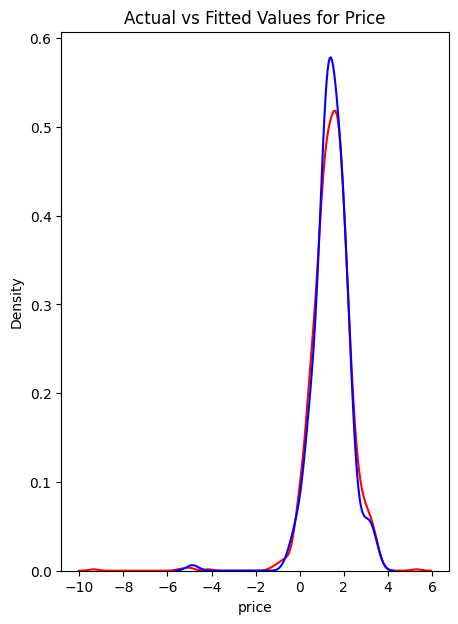

In [150]:
import seaborn as sns
plt.figure(figsize=(5, 7))


ax = sns.distplot(y, hist=False, color="r", label="Actual Value")
sns.distplot(y_pred, hist=False, color="b", label="Fitted Values" , ax=ax)


plt.title('Actual vs Fitted Values for Price')


plt.show()
plt.close()

In [151]:
param = {'max_depth': 5,
         'subsample': 0.8,
         'min_child_weight': 1,
         'colsample_bytree': 0.9,
         'learning_rate': 0.1,
         'reg_alpha': 0,
         'reg_lambda': 0,
         'eval_metric': ['logloss','rmse']}

epochs = 20
evals_result={}

xgbtrain = xgb.DMatrix(X_train._get_numeric_data(), y_train)
xgbTest = xgb.DMatrix(X_test._get_numeric_data(), y_test)
watchlist = [(xgbTest,'eval'), (xgbtrain,'train')]
model = xgb.train(param, xgbtrain, epochs, watchlist,evals_result=evals_result)

[0]	eval-logloss:0.35016	eval-rmse:1.12080	train-logloss:-0.40159	train-rmse:1.22262
[1]	eval-logloss:-0.50044	eval-rmse:1.03477	train-logloss:-2.08282	train-rmse:1.13383
[2]	eval-logloss:-2.79381	eval-rmse:0.96327	train-logloss:-4.32041	train-rmse:1.06332
[3]	eval-logloss:-7.23097	eval-rmse:0.89913	train-logloss:-8.57911	train-rmse:0.99515
[4]	eval-logloss:-12.34820	eval-rmse:0.84140	train-logloss:-13.10272	train-rmse:0.93739
[5]	eval-logloss:-14.89312	eval-rmse:0.79605	train-logloss:-16.38192	train-rmse:0.89112
[6]	eval-logloss:-16.44019	eval-rmse:0.75824	train-logloss:-18.12883	train-rmse:0.84681
[7]	eval-logloss:-16.96168	eval-rmse:0.72517	train-logloss:-18.68284	train-rmse:0.80788
[8]	eval-logloss:-17.37689	eval-rmse:0.69848	train-logloss:-19.21933	train-rmse:0.77584
[9]	eval-logloss:-17.67202	eval-rmse:0.67471	train-logloss:-19.33650	train-rmse:0.74694
[10]	eval-logloss:-17.99178	eval-rmse:0.65531	train-logloss:-19.93442	train-rmse:0.72452
[11]	eval-logloss:-17.96878	eval-rmse:0.

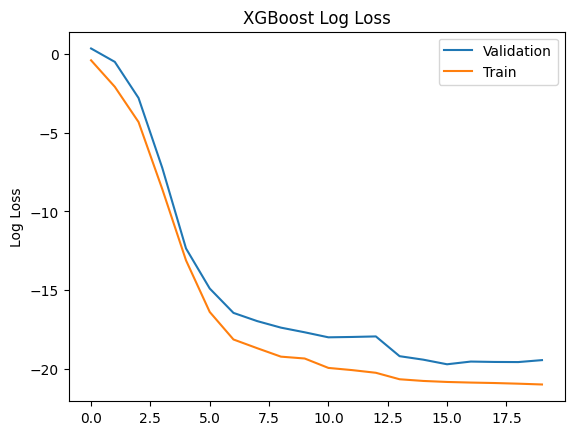

In [152]:
fig, ax = plt.subplots()
x_axis = range(0, epochs)

ax.plot(x_axis, evals_result['eval']['logloss'], label='Validation')
ax.plot(x_axis, evals_result['train']['logloss'], label='Train')
ax.legend()
plt.ylabel('Log Loss')

plt.title('XGBoost Log Loss')

plt.show()

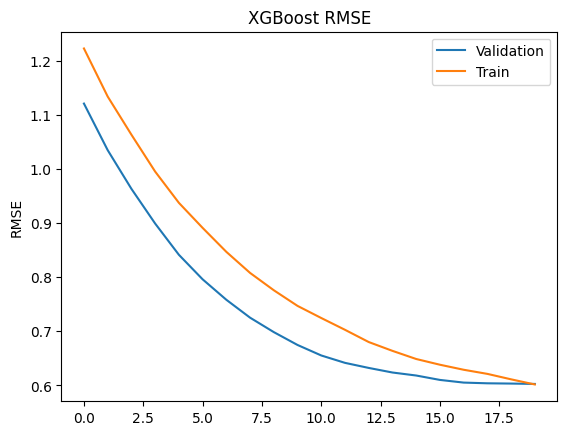

In [153]:
fig, ax = plt.subplots()
x_axis = range(0, epochs)

ax.plot(x_axis, evals_result['eval']['rmse'], label='Validation')
ax.plot(x_axis, evals_result['train']['rmse'], label='Train')
ax.legend()
plt.ylabel('RMSE')

plt.title('XGBoost RMSE')

plt.show()

# Comparing Models

In [154]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, make_scorer

In [156]:
model_names = ['Lasso', 'KNeighborsRegressor', 'SVR', 'Decision Tree Regressor', 'XGBoost Regressor']
models = [Lasso(alpha=0.001),
          KNeighborsRegressor(n_neighbors=3),
          SVR(kernel='rbf',C=10000,epsilon=0.1),
          DecisionTreeRegressor(
          min_samples_split=10,
          max_features="auto",
          random_state=2,
          max_depth=9),
          xgb.XGBRegressor(objective='reg:squarederror')
          ]

metrics = ['R2 Score', 'MAE']

scores = []
mae_scores = []
accuracy_scores = []

for model in models:
    pipe = Pipeline([('step1',ohe),('step2',model)])
    pipe.fit(X_train,y_train)
    y_pred = pipe.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    errors = abs(y_pred - y_test)
    mape = 100 * (errors / y_test)
    acc = 100 - np.mean(mape)

    scores.append(r2)
    mae_scores.append(mae)
    accuracy_scores.append(acc)


results = {'Model': model_names, 'R2 Score': scores, 'MAE': mae_scores, 'Accuracy': accuracy_scores}

results_df = pd.DataFrame(results)
results_df

,Model,R2 Score,MAE,Accuracy
0,Lasso,0.442790,0.398443,78.897655
1,KNeighborsRegressor,0.457960,0.347008,77.862741
2,SVR,0.029215,0.408848,61.847030
3,Decision Tree Regressor,0.369305,0.374403,81.333518
4,XGBoost Regressor,0.371809,0.324727,73.245266


# K-fold Visualization

In [157]:
from sklearn.model_selection import cross_val_score

## XGBoost Regressor

In [159]:
k_range = list(range(2, 12))
k_scores = []
for k in k_range:
    ohe = ColumnTransformer(transformers=[
        ('col_tnf',OneHotEncoder(sparse=False,drop='first'),[1,3,6,10,9])
    ],remainder='passthrough')


    model = xgb.XGBRegressor(objective='reg:squarederror')

    pipe = Pipeline([
        ('step1',ohe),
        ('step2',model)
    ])

    scores = cross_val_score(pipe, X, y, cv = k)
    k_scores.append(scores.mean())
print(k_scores)

[nan, 0.02899419621829809, 0.39723953714241106, nan, 0.37857641257203717, 0.4040012818936625, 0.3782300448347342, 0.4013234298871622, 0.42054209690677197, 0.4499232613997497]


Text(0, 0.5, 'Cross-Validated-Accuracy')

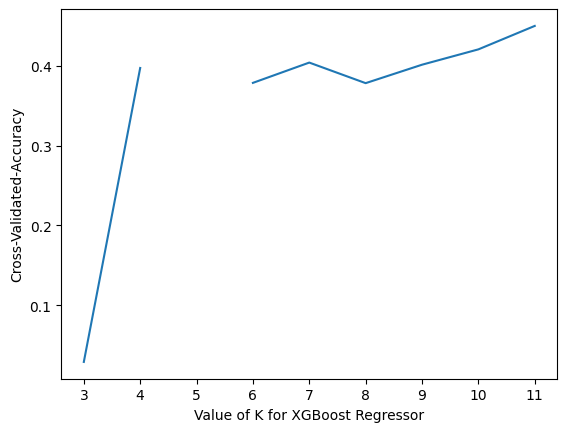

In [160]:
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for XGBoost Regressor')
plt.ylabel('Cross-Validated-Accuracy')

## Desicion Tree Regressor

In [161]:
k_range = list(range(2, 12))
k_scores = []
for k in k_range:
    ohe = ColumnTransformer(transformers=[
        ('col_tnf',OneHotEncoder(sparse=False,drop='first'),[1,3,6,10,9])
    ],remainder='passthrough')


    model = DecisionTreeRegressor(
    min_samples_split=10,
    max_features="auto",
    random_state=2,
    max_depth=9
    )

    pipe = Pipeline([
        ('step1',ohe),
        ('step2',model)
    ])

    scores = cross_val_score(pipe, X, y, cv = k)
    k_scores.append(scores.mean())
print(k_scores)

[nan, 0.028496314071572493, 0.3029206084017533, nan, 0.26587709738686766, 0.33169071735462213, 0.3155112335316351, 0.3467812448657799, 0.331141946970838, 0.38237134109511656]


Text(0, 0.5, 'Cross-Validated-Accuracy')

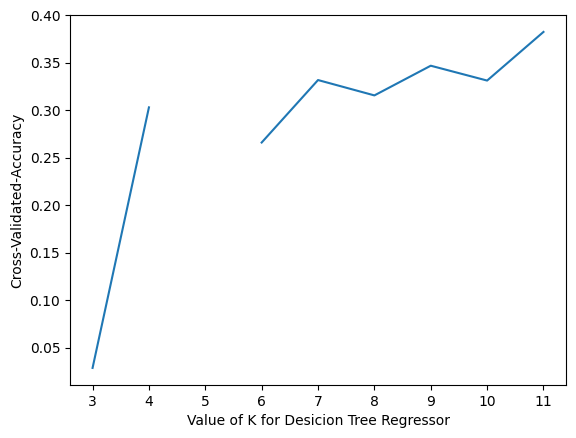

In [162]:
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for Desicion Tree Regressor')
plt.ylabel('Cross-Validated-Accuracy')